Much of this code is taken from [DCGAN Tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

We are following the paper [Do GANS Learn the Distribution: Some Theory and Empirics, Arora et al (2018)](https://arxiv.org/pdf/1703.00573.pdf).

We will be using their proposed Birthday Paradox test to evaluate some bound on the estimated size of the distribution's support. This will be done on several different discriminator sizes.
As described in the paper, this is achieved by increasing the number of output channels, which increases the size of the discriminator as the square.

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import datetime
import tensorflow as tf
import pickle

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


Below we have the hyperparameters for our GAN

In [2]:
# Root directory for dataset
dataroot = "C:\Projects\DiverseGAN\celeba"
#dataroot = "C:\Projects\DiverseGAN\celeba\img_align_celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

We load the data and plot a grid of training images

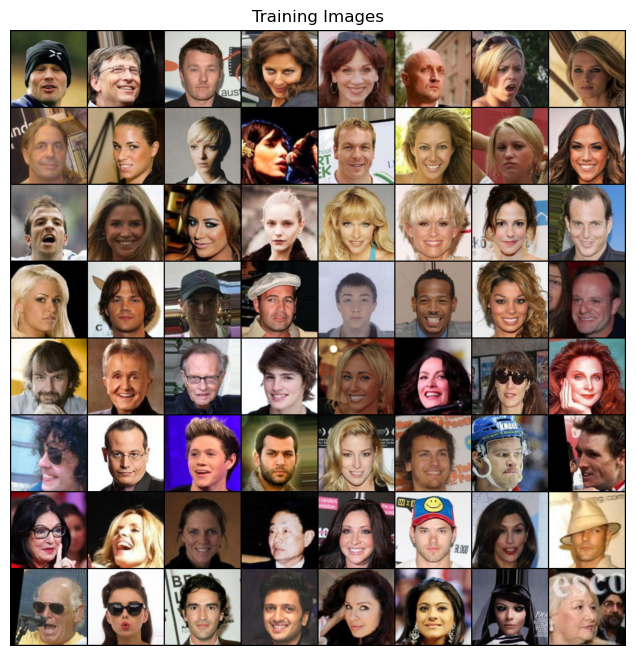

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset'
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

model_transform=transforms.Resize(image_size)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(enumerate(dataloader))[1]
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Below we define and initialize the Generator and Discriminator networks. These are 5 layer convolutional CNNs where we may if we want vary the number of features as the paper describes.
The weights are initialized randomly but from a specified distribution.

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
generator_transform = transforms.Resize(64) 
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # this layer does H+3, W+3 (we start with z with H,W = 1,1 )
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # the below layers do 2H, 2W
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            #state size (nc) x 64 x 64
            # state size. (nc) x image_size x image_size
        )

    def forward(self, z):
        x = self.main(z)
        return generator_transform(x)

In [6]:
discriminator_transform = transforms.Resize(64) 
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x image_size x image_size
            # input is (nc) x 64 x 64
            # layers below do H/2, W/2
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x H/2 x W/2
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # this layer does H-3, W-3
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = discriminator_transform(x)
        return self.main(x)

Below we train the GANs for a certain size for our adversarial nets. We will save the weights as well as some of the training metrics.

In [7]:
def trainGAN(ndf, ngf = ngf, quiet = False):
    t0 = datetime.datetime.now()
    
    # Create the Generator
    netG = Generator(ngpu).to(device)
    
    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))
    netG.apply(weights_init)
    
    # Create the Discriminator
    netD = Discriminator(ngpu).to(device)

    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))
    netD.apply(weights_init)
    
    # Initialize BCELoss function
    criterion = nn.BCELoss()

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    
    # Training Loop

    # Lists to keep track of progress
    G_losses = []
    D_losses = []
    iters = 0

    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients (since we have not done zero_grad yet)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0 and not quiet: 
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
        
    pathG = "C:\Projects\DiverseGAN\models\ganG_{}_{}".format(ndf, ngf)
    pathD = "C:\Projects\DiverseGAN\models\ganD_{}_{}".format(ndf, ngf)
    torch.save(netG.state_dict(), pathG )
    torch.save(netD.state_dict(), pathD) 
    
    with open("C:\Projects\DiverseGAN\models\metrics_{}_{}".format(ndf, ngf), 'wb') as handle:
        pickle.dump((G_losses, D_losses), handle, protocol=pickle.HIGHEST_PROTOCOL)

## Training

Here we train our various GANS with different discriminator sizes

In [29]:
torch.manual_seed(1)

ndfs = np.arange(16,136,8)
ngfs = [2000]

t0 = datetime.datetime.now()
for ndf in ndfs: 
    for ngf in ngfs:
        t00 = datetime.datetime.now()
        print('Training GAN on ndf = {} ngf = {}'.format(ndf, ngf))
        trainGAN(ndf, ngf = ngf, quiet = True)
        print('RUNTIME GAN ndf = {} ngf = {} is {}'.format(ndf, ngf, datetime.datetime.now()-t00))
    
print('TOTAL RUNTIME {}'.format(datetime.datetime.now()-t0))

Training GAN on ndf = 500 ngf = 2000


OutOfMemoryError: CUDA out of memory. Tried to allocate 7.63 GiB (GPU 0; 8.00 GiB total capacity; 2.85 GiB already allocated; 2.42 GiB free; 3.13 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Below we look at the 20 closest pairs of images for GANS of various sizes.

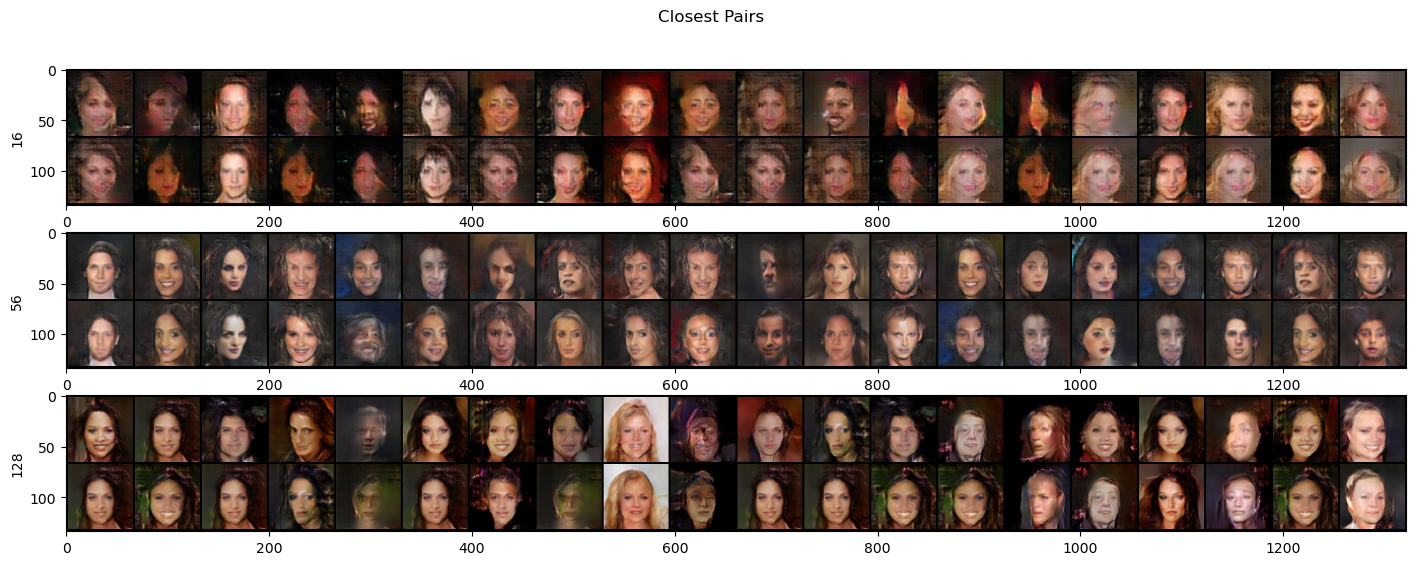

In [7]:
torch.manual_seed(1)

#decide to keep the same batch of noise for all models
sample_size = 5000
sample_noise = torch.randn(sample_size, nz, 1, 1, device=device)

netG = Generator(ngpu).to(device)
netG.train(False)
netD = Discriminator(ngpu).to(device)
netD.train(False)

#ndfs = np.arange(16,136,8)
ndfs = np.array([16, 56, 128])
ngfs = [64]

pairsfvD = []

for ndf in ndfs:
    for ngf in ngfs:
        #load Generator model
        pathG = "C:\Projects\DiverseGAN\models\ganG_{}_{}".format(ndf, ngf)
        netG.load_state_dict(torch.load(pathG))
        
        #Generate fake batch
        with torch.no_grad():
            fake = netG(sample_noise).detach()
            
        #Compute (unique) pair distances
        pair_dist = torch.cdist(fake.view(1,sample_size,-1), fake.view(1,sample_size,-1), p=2)
        pair_dist = pair_dist - torch.tril(pair_dist-pair_dist.max())
        
        #Get the top 20 closest pairs, stored as 2*20 = 40 batch size
        values, indices = tf.math.top_k(-pair_dist.cpu().flatten(), k=20)
        indices = np.unravel_index(indices, (sample_size,sample_size) )
        pairsf = torch.stack((fake[indices[0]], fake[indices[1]]),0).flatten(0,1)
        
        #append to pairsfvD
        pairsfvD.append(pairsf)
        
fig, axs = plt.subplots(ndfs.shape[0], figsize = (20, 2*ndfs.shape[0]))
fig.suptitle('Closest Pairs')
for i in range(ndfs.shape[0]):
    axs[i].imshow(np.transpose(vutils.make_grid(pairsfvD[i], nrow = 20, padding=2, normalize=True).cpu(),(1,2,0)))
    axs[i].set(ylabel = ndfs[i])

Here we will do our testing to find at what size we have $\geq .5$ probability of a collision. We will input a fixed batch size of noise into the GAN and repeat this, counting how many times out of 10
we see a collision. We decrease the batch size until there are less than 5 times. Using the metric in the paper, the diversity we say is the square of this batch size needed to have greater than $.5$ chance of a collision.

(Note: what is considered a collision is determined by the human subject and can vary quite a lot subjectively for what we want)

In [7]:
netG = Generator(ngpu).to(device)
netG.train(False)
netD = Discriminator(ngpu).to(device)
netD.train(False)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

Here we will generate 10 instances of the 20 closest pairs for each discriminator size. If we have $\geq 5/10$ with a collision, then we determine that this batch size gives probability $\geq .5$ of a collision. 

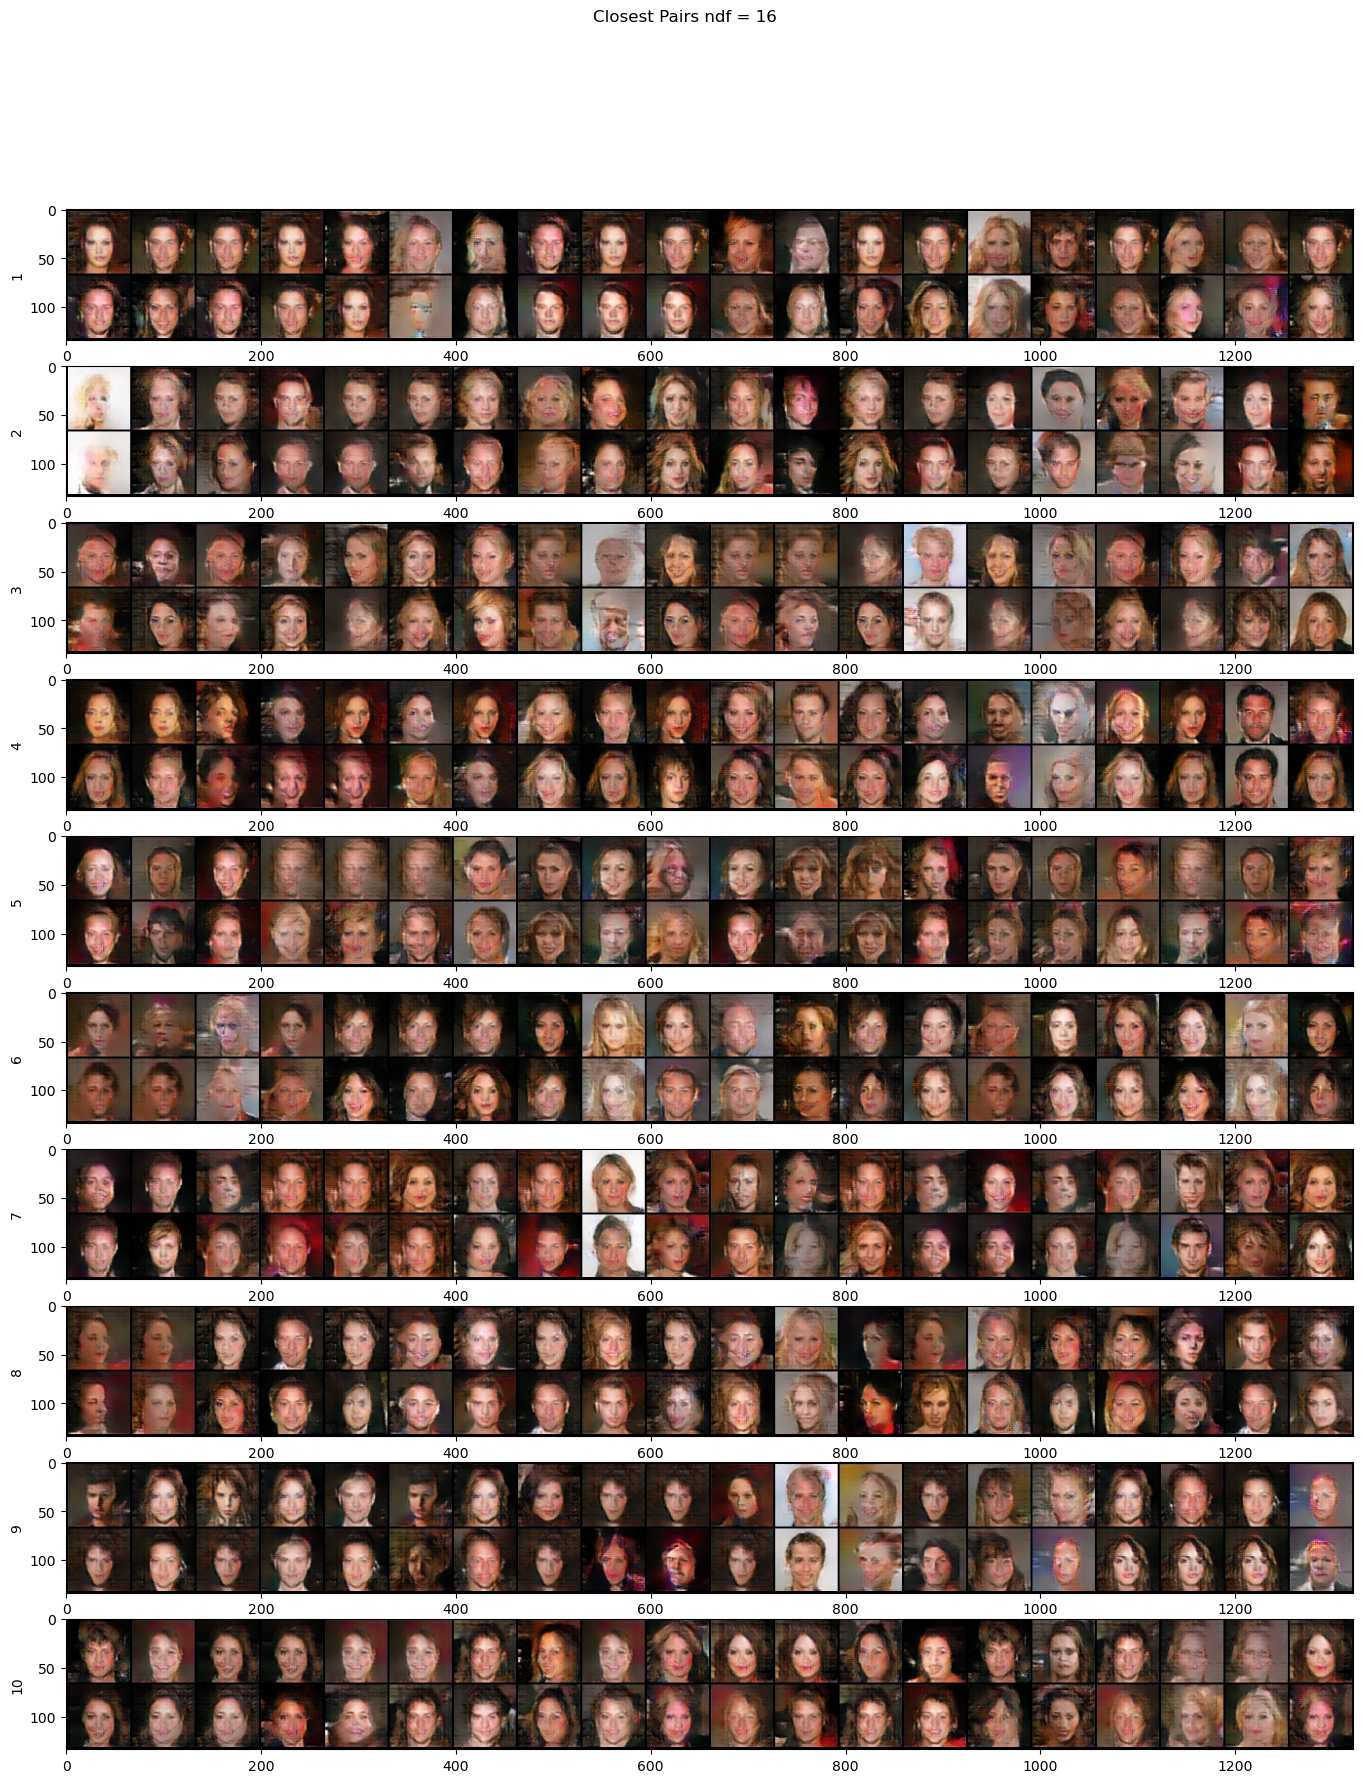

In [75]:
ngf = 64
#these worked
ndfs = [16, 24, 32, 40, 48, 56, 64, 72, 88, 96, 128]

ndf = ndfs[0]

pathG = "C:\Projects\DiverseGAN\models\ganG_{}_{}".format(ndf, ngf)
netG.load_state_dict(torch.load(pathG))

sample_size = 500

pairsfvD = []

for _ in range(10):
        
    #Generate fake batch
    with torch.no_grad():
        fake = netG(torch.randn(sample_size, nz, 1, 1, device=device)).detach()
            
    #Compute (unique) pair distances
    pair_dist = torch.cdist(fake.view(1,sample_size,-1), fake.view(1,sample_size,-1), p=2)
    pair_dist = pair_dist - torch.tril(pair_dist-pair_dist.max())
        
    #Get the top 20 closest pairs, stored as 2*20 = 40 batch size
    values, indices = tf.math.top_k(-pair_dist.cpu().flatten(), k=20)
    indices = np.unravel_index(indices, (sample_size,sample_size) )
    pairsf = torch.stack((fake[indices[0]], fake[indices[1]]),0).flatten(0,1)
        
    #append to pairsfvD
    pairsfvD.append(pairsf)
        
fig, axs = plt.subplots(10, figsize = (20, 2*10))
fig.suptitle('Closest Pairs ndf = {}'.format(ndf))
for i in range(10):
    axs[i].imshow(np.transpose(vutils.make_grid(pairsfvD[i], nrow = 20, padding=2, normalize=True).cpu(),(1,2,0)))
    axs[i].set(ylabel = i+1)

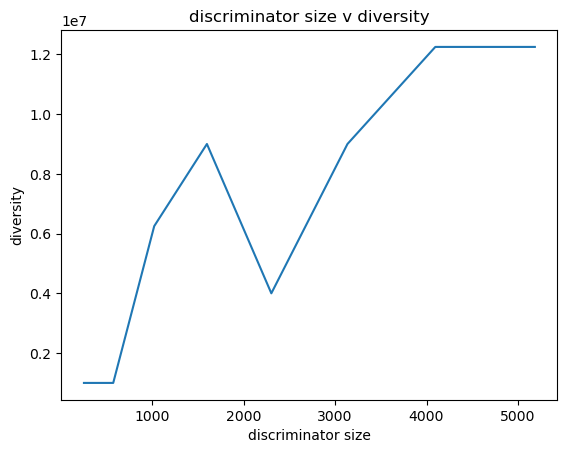

In [80]:
bs = [1000, 1000, 2500, 3000, 2000, 3000, 3500, 3500]

plt.title('discriminator size v diversity')
plt.plot([ ndfs[j]**2 for j in range(len(bs))], [ bs[j]**2 for j in range(len(bs))])
plt.xlabel('discriminator size')
plt.ylabel('diversity')
plt.show()

Below we investigate whether the closeness in the generated images can be explained by the closeness of points in the latent space.

In [8]:
ngf = 64
#these worked
ndfs = [16, 24, 32, 40, 48, 56, 64, 72, 88, 96, 128]

sample_size = 3000

dindout = [ [ [], [], [], [] ] for j in range(len(ndfs))]

for j in range(len(ndfs)):
    ndf = ndfs[j]
    print(ndf)
    pathG = "C:\Projects\DiverseGAN\models\ganG_{}_{}".format(ndf, ngf)
    netG.load_state_dict(torch.load(pathG))
    for i in range(100):
        #Generate fake batch
        noise = torch.randn(sample_size, nz, 1, 1, device=device)
        with torch.no_grad():
            fake = netG(noise).detach()
        
        #Compute (unique) pair distances
        pair_dist = torch.cdist(fake.view(1,sample_size,-1), fake.view(1,sample_size,-1), p=2)
        pair_dist = pair_dist - torch.tril(pair_dist-pair_dist.max())
        
        #Get the top 20 closest pairs, stored as 2*20 = 40 batch size
        values, indices_closest = tf.math.top_k(-pair_dist.cpu().flatten(), k=20)
        indices_closest = np.unravel_index(indices_closest, (sample_size,sample_size) )
        
        #Get 20 pairs (unique)
        indices_any = np.where( (pair_dist < pair_dist.max()).cpu().flatten() == True)
        indices_any = (indices_any[0][np.random.permutation(indices_any[0].size)[:20]])
        indices_any = np.unravel_index(indices_any, (sample_size,sample_size) )
        
        dz_closest = torch.norm(noise[indices_closest[0]] - noise[indices_closest[1]], p = 2, dim = (1,2,3) )
        dx_closest = torch.norm(fake[indices_closest[0]] - fake[indices_closest[1]], p = 2, dim = (1,2,3) )
        
        dz_any = torch.norm(noise[indices_any[0]] - noise[indices_any[1]], p = 2, dim = (1,2,3) )
        dx_any = torch.norm(fake[indices_any[0]] - fake[indices_any[1]], p = 2, dim = (1,2,3) )
        
        dindout[j][0].extend(dz_closest.tolist())
        dindout[j][1].extend(dx_closest.tolist())
        dindout[j][2].extend(dz_any.tolist())
        dindout[j][3].extend(dx_any.tolist())  
        
with open("C:\Projects\DiverseGAN\models\dindout", 'wb') as handle:
    pickle.dump(dindout, handle, protocol=pickle.HIGHEST_PROTOCOL)

16


KeyboardInterrupt: 

From the plots, we see that there is more going on than simply close points in the latent space giving close points in the generated image spaces.

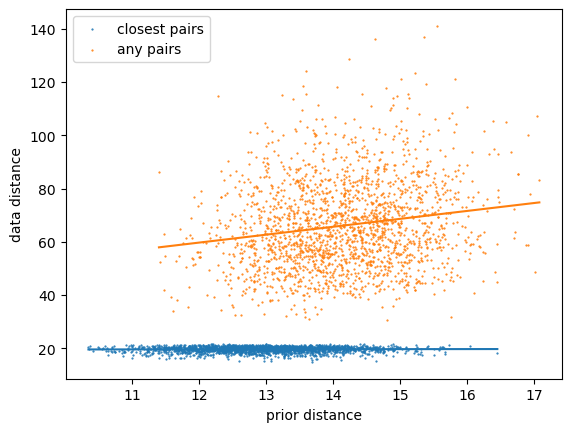

Rscore for closest pairs: 0.0004763605413208305
coef for closest pairs: [0.02419592]
Rscore for any pairs: 0.03091127806553151
coef for any pairs: [2.97261423]


In [64]:
from sklearn.linear_model import LinearRegression

with open("C:\Projects\DiverseGAN\models\dindout", 'rb') as handle:
    dindout = pickle.load(handle)

x1, y1, x2, y2 = dindout[4]
x1, y1, x2, y2 = np.array(x1), np.array(y1), np.array(x2), np.array(y2)

##remove outliers
id1 = np.argsort(x1)
id2 = np.argsort(x2)
#sort
x1, y1, x2, y2 = x1[id1], y1[id1], x2[id2], y2[id2]
x1, y1, x2, y2 = x1[5:], y1[5:], x2[5:], y2[5:]

reg1 = LinearRegression().fit(x1.reshape(-1,1), y1)
reg2 = LinearRegression().fit(x2.reshape(-1,1), y2)

plt.scatter(x1, y1, s=.3, label = 'closest pairs')
plt.plot(np.unique(x1), reg1.intercept_ + reg1.coef_*np.unique(x1))
plt.scatter(x2, y2, s=.3, label = 'any pairs')
plt.plot(np.unique(x2), reg2.intercept_ + reg2.coef_*np.unique(x2))
plt.xlabel('prior distance')
plt.ylabel('data distance')
plt.legend()
plt.show()

print('Rscore for closest pairs: {}'.format(reg1.score(x1.reshape(-1,1), y1)))
print('coef for closest pairs: {}'.format(reg1.coef_))

print('Rscore for any pairs: {}'.format(reg2.score(x2.reshape(-1,1), y2)))
print('coef for any pairs: {}'.format(reg2.coef_))